In [31]:
import librosa, librosa.display
import noisereduce as nr
import numpy as np
from glob import glob
import pandas as pd

# custom scripts
from util import data_address
from preprocessing_pipeline import *

In [32]:
PATH_DATA = data_address + 'VOiCES_devkit/'
PATH_TRAIN_INDEX = PATH_DATA + 'references/train_index.csv'
PATH_TEST_INDEX = PATH_DATA + 'references/test_index.csv'

In [33]:
df_train = pd.read_csv(PATH_TRAIN_INDEX)
df_test = pd.read_csv(PATH_TEST_INDEX)

In [34]:
df_train["category"] = "train"
df_test["category"] = "test"
df_merged = pd.concat([df_train, df_test], ignore_index=True)

In [35]:
df_merged["full_path"] = PATH_DATA + df_merged["filename"]
df_merged["full_path_source"] = PATH_DATA + df_merged["source"]

In [36]:
# sort by speaker, segment, room, distractor, degrees, mic
df_merged = df_merged.sort_values(by=["speaker", "segment", "room", "distractor", "degrees", "mic"]).reset_index(drop=True)

In [37]:
df_merged

,index,chapter,degrees,distractor,filename,gender,mic,query_name,room,segment,...,transcript,noisy_length,noisy_sr,noisy_time,source_length,source_sr,source_time,category,full_path,full_path_source
0,893,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
1,895,4137,150,babb,distant-16k/speech/train/rm1/babb/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-babb-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
2,280,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
3,282,4137,150,musi,distant-16k/speech/train/rm1/musi/sp0032/Lab41...,F,5,Lab41-SRI-VOiCES-rm1-musi-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
4,2969,4137,150,none,distant-16k/speech/train/rm1/none/sp0032/Lab41...,F,1,Lab41-SRI-VOiCES-rm1-none-sp0032-ch004137-sg00...,rm1,7,...,few persons can arrive at anything like the ag...,257120,16000,16.07,257120,16000,16.07,train,./data/VOiCES_devkit/distant-16k/speech/train/...,./data/VOiCES_devkit/source-16k/train/sp0032/L...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19195,780,283228,130,musi,distant-16k/speech/test/rm4/musi/sp8855/Lab41-...,M,5,Lab41-SRI-VOiCES-rm4-musi-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19196,1471,283228,130,none,distant-16k/speech/test/rm4/none/sp8855/Lab41-...,M,1,Lab41-SRI-VOiCES-rm4-none-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19197,1470,283228,130,none,distant-16k/speech/test/rm4/none/sp8855/Lab41-...,M,5,Lab41-SRI-VOiCES-rm4-none-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...
19198,975,283228,130,tele,distant-16k/speech/test/rm4/tele/sp8855/Lab41-...,M,1,Lab41-SRI-VOiCES-rm4-tele-sp8855-ch283228-sg00...,rm4,11,...,i was yet left anxious and thoughtful there wa...,240640,16000,15.04,240640,16000,15.04,test,./data/VOiCES_devkit/distant-16k/speech/test/r...,./data/VOiCES_devkit/source-16k/test/sp8855/La...


In [38]:
df = df_merged.copy() # working df
df["full_path"][64] ## same 32 speaker-segment observations
## if no difference after the pre-processing pipeline?

'./data/VOiCES_devkit/distant-16k/speech/train/rm1/babb/sp0083/Lab41-SRI-VOiCES-rm1-babb-sp0083-ch009960-sg0031-mc01-stu-clo-dg110.wav'

# Explore Signal Pre vs Post Noise Reduction

In [39]:
import librosa
import matplotlib.pyplot as plt

def display_waveplot(signal, sr):
    """
    Display waveplot of audio signal
    """
    librosa.display.waveshow(signal, sr=sr)

def plot_decorate(row, source=False, xlabel="Time (s)", ylabel="Amplitude", subtitle=""):
    """
    Decorate plot with metadata
    """
    plt.figure(figsize=(15, 5))
    if source:
        plt.title(f"Speaker: {row['speaker']}, Segment: {row['segment']}", fontsize=20)
    else:
        plt.title(f"Speaker: {row['speaker']}, Segment: {row['segment']}, Room: {row['room']}, Distractor: "
              f"{row['distractor']}, Degrees: {row['degrees']}, Mic: {row['mic']}", fontsize=20)
    if subtitle:
        plt.suptitle(subtitle, fontsize=20, y=1.05)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)

def display_spectrogram(spectrogram, title=""):
    """
    Display spectrogram
    """
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(spectrogram)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)

AttributeError: '_process_plot_var_args' object has no attribute 'prop_cycler'

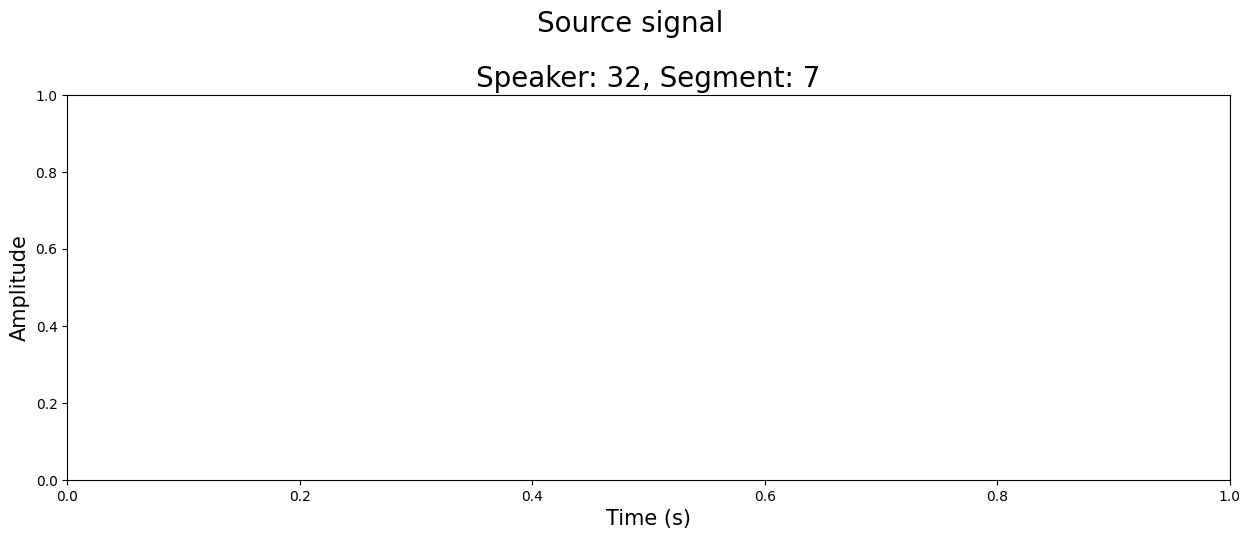

In [40]:

row = df.iloc[0]
signal, sr = librosa.load(row["full_path"])
source_signal, source_sr = librosa.load(row["full_path_source"])

plot_decorate(row, source=True, subtitle="Source signal")
display_waveplot(source_signal, source_sr)

plot_decorate(row, subtitle="Original signal")
display_waveplot(signal, sr)

plot_decorate(row, subtitle="Signal after noise reduction")
display_waveplot(reduce_noise(signal, sr), sr)

If the unwanted noise or distractors are clearly visible or identifiable in the time-domain representation of the audio signal, performing noise reduction directly in the time domain (before conversion to spectrogram) may preferred. This can help preserve the essential characteristics of the signal before further analysis, such as generating spectrograms for subsequent processing steps in tasks like speaker verification.

# Pre-processing pipeline


In [41]:
# Load 10 random samples from the train category
df = df_merged[df_merged["category"] == "train"]
df = df.sample(10, random_state=42).reset_index(drop=True)

print(df)

   index  chapter  degrees distractor  \
0   8109   164461      110       none   
1   9515    34605      170       tele   
2   4238    12312       40       musi   
3    197    28452       20       musi   
4  11476   128145      150       tele   
5  11138   292138      150       babb   
6   7114    27120        0       babb   
7   3251     4137      150       babb   
8  11996    82991       60       tele   
9   8448   123172       20       none   

                                            filename gender  mic  \
0  distant-16k/speech/train/rm3/none/sp2162/Lab41...      M    5   
1  distant-16k/speech/train/rm3/tele/sp6147/Lab41...      F    1   
2  distant-16k/speech/train/rm2/musi/sp0254/Lab41...      M    5   
3  distant-16k/speech/train/rm1/musi/sp3235/Lab41...      F    1   
4  distant-16k/speech/train/rm4/tele/sp1271/Lab41...      M    5   
5  distant-16k/speech/train/rm4/babb/sp8605/Lab41...      F    1   
6  distant-16k/speech/train/rm3/babb/sp1259/Lab41...      F    5   
7  d

In [42]:
reduce_noise(signal, sr).shape

(354344,)

In [18]:
# Example
signals_and_srs = [librosa.load(row["full_path"]) for _, row in df.iterrows()]

In [19]:

def reduce_noise(signal, sr):
    """
    Reduce noise from spectrogram
    """
    noise_reduced = nr.reduce_noise(signal, sr=sr)
    return noise_reduced

def pad_trim_audio(signal, sr, length=15):
    """
    Pad or trim audio signal to a fixed length
    """
    target_length = sr * length
    if len(signal) > target_length:
        clean_signal = signal[:target_length]
    elif len(signal) < target_length:
        pad_width = target_length - len(signal)
        clean_signal = np.pad(signal, (0, pad_width), 'constant')
    return clean_signal

# may need to play around with these parameters
def compute_spectrogram(signal, n_fft=2048):
    """
    Compute spectrogram of audio signal
    win_length: window length in samples, smaller values for better temporal resolution. Default is win_length=n_fft
    hop_length: number of samples between successive frames, smaller values increase number of columns D . Default
    is hop_length=win_length//4
    """
    spectrogram = librosa.stft(signal, n_fft=n_fft)
    spectrogram = np.abs(spectrogram)
    return spectrogram

def convert_to_decibel(spectrogram):
    """
    Convert spectrogram to decibel
    """
    spectrogram = librosa.amplitude_to_db(spectrogram, ref=np.max)
    return spectrogram

def compute_melspectrogram(signal, n_mels=128):
    """
    Extract mel-spectrogram from audio signal
    """
    spectrogram = librosa.feature.melspectrogram(S=signal, n_mels=n_mels)
    return spectrogram

def compute_mfcc(melspectrogram, n_mfcc=20):
    """
    Extract MFCC from Mel-spectrogram
    """
    spectrogram = librosa.feature.mfcc(S=melspectrogram, n_mfcc=n_mfcc)
    return spectrogram




In [43]:
signal, sr = signals_and_srs[0][0]
signal2 = pad_trim_audio(signal, sr)
signal3 = compute_spectrogram(signal2)
signal4 = convert_to_decibel(signal3)

## 2 approaches: Mel-spectogram and MFCCs

# extract Mel-spectrogram from STFT
signal5 = compute_melspectrogram(signal4)
# extract MFCCs from Mel-spectrogram
signal6 = compute_mfcc(signal5, n_mfcc=40)


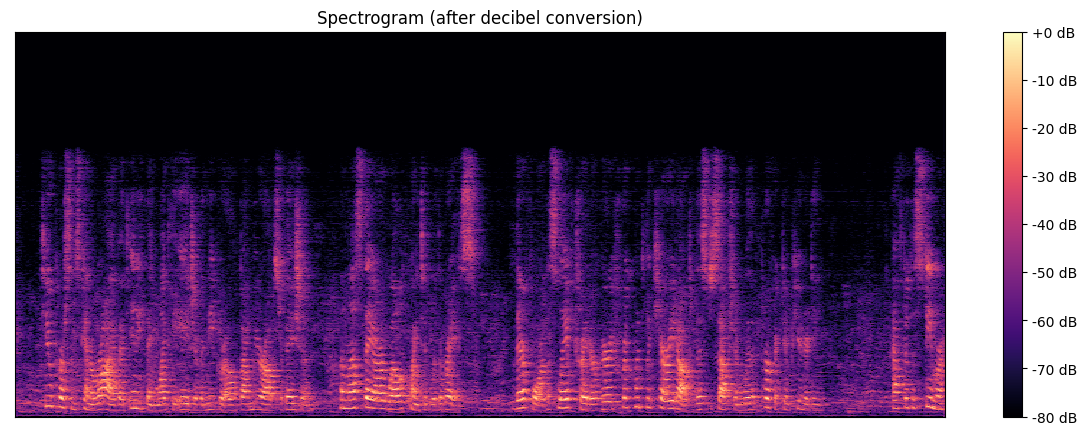

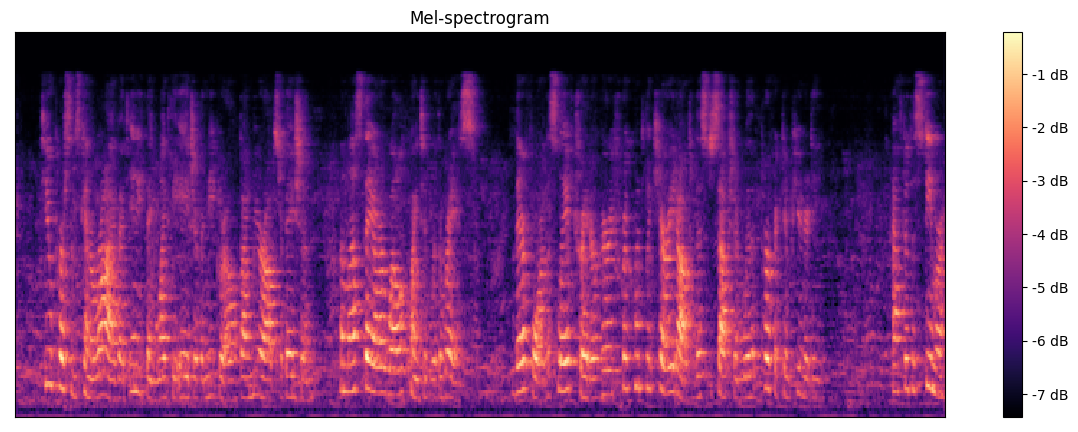

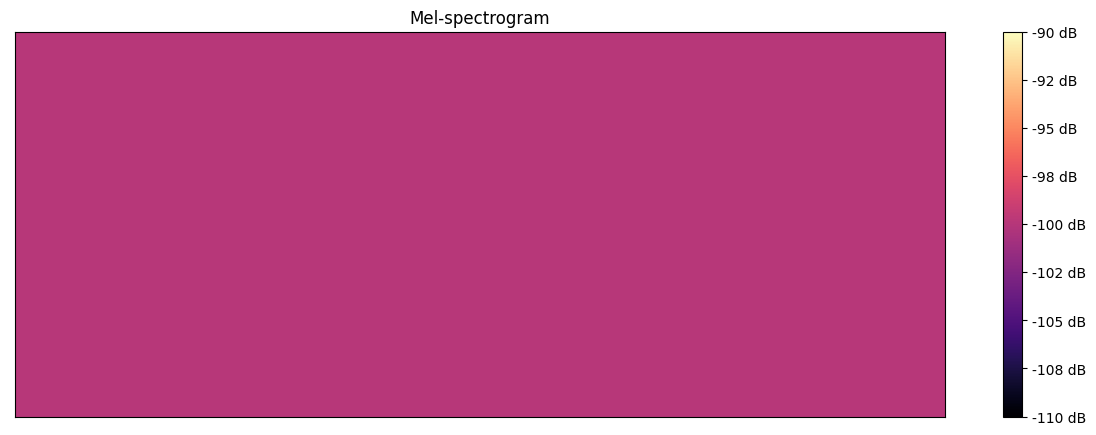

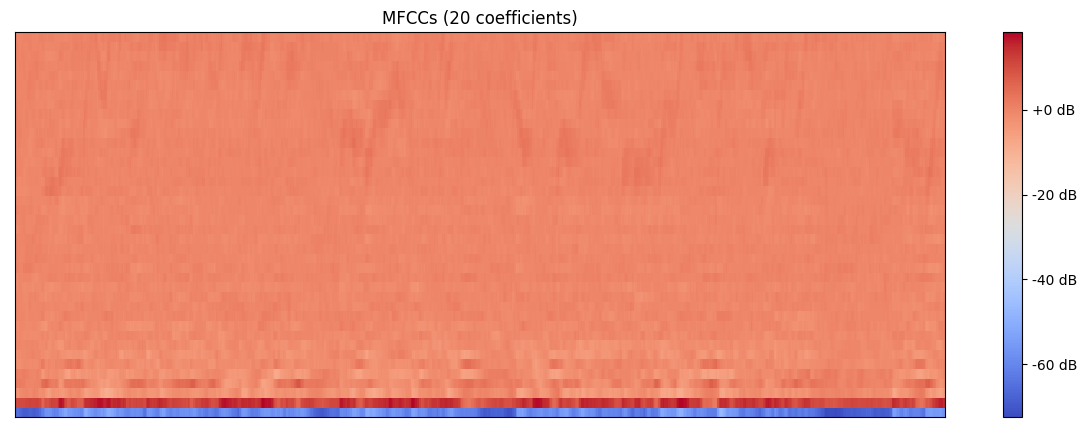

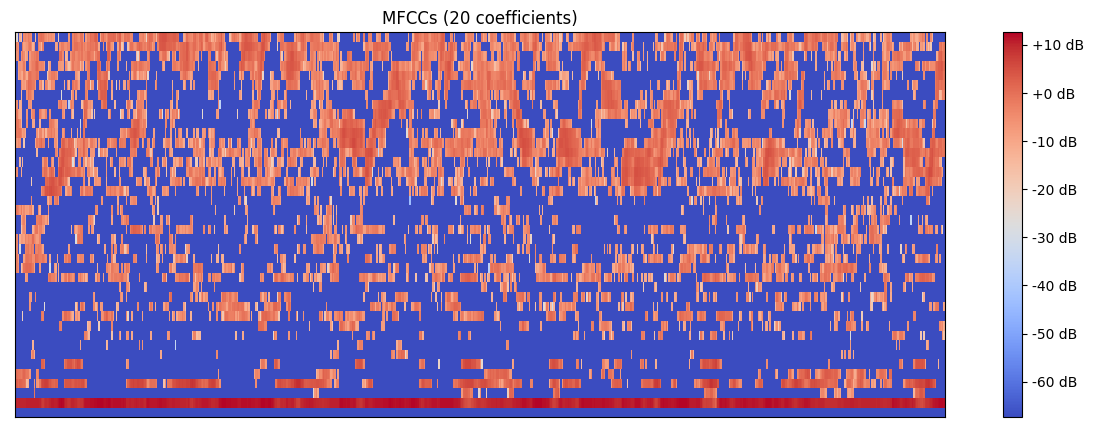

In [141]:
display_spectrogram(signal4, title="Spectrogram (after decibel conversion)")

display_spectrogram(signal5, title="Mel-spectrogram")

display_spectrogram(signal6, title="MFCCs (20 coefficients)")


The Mel spectrogram provides a detailed representation of the energy distribution across Mel-frequency bands, while MFCCs offer a compact representation of the spectral characteristics, often used as features in various audio processing applications.

### Mel-spectrogram

- high-dimensional representation of the spectral content of the audio signal. Each time step of the spectrogram
corresponds to a different frequency band.
- Mel spectrograms retain detailed information about the energy distribution across different frequency bands
- visually interpretable

### MFCCs

- MFCCs offer a more compact representation compared to Mel spectrograms. The discrete cosine transform (DCT) applied to the logarithm of the Mel spectrogram results in a reduced set of coefficients.
- First few MFCC coefficients often capture the most relevant spectral characteristics, making them efficient for tasks where the detailed frequency content may not be as crucial.




CNNs can learn to extract relevant features from the spectrogram representation, while RNNs can learn to model the temporal dependencies in the spectrogram sequence. Given enough computational resources, using Mel spectrograms may be better. In our case of distinguishing speakers based on their voice characteristics, the detailed frequency information in Mel spectrograms might be beneficial to a deep neural network.

Task: Train separate models with each representation and compare their performance on our validation set.